# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

## ⚙️ Import Libraries

In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ConvNeXtBase
seed = 42
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


## ⏳ Load the Data

In [2]:
file_path = "/kaggle/input/mars-data/mars_for_students.npz"

data = np.load(file_path)

training_set = data["training_set"]
images = training_set[:, 0]
labels = training_set[:, 1]


print(f"Training X shape: {images.shape}")
print(f"Training y shape: {labels.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)


In [3]:
# Split the paths (not the data) into training, validation, and test sets
print("Splitting data...")
# 10% of input data to both test and validation sets
test_ratio = 0.05 
validation_ratio = 0.05 / 0.9 

train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
    images, labels, test_size=test_ratio, random_state=seed
)
train_img, val_img, train_lbl, val_lbl = train_test_split(
    train_val_img, train_val_lbl, test_size=validation_ratio, random_state=seed
)
print("Data splitted!")

print(f"\nNumber of images:")
print(f"Train: {len(train_img)}")
print(f"Validation: {len(val_img)}")
print(f"Test: {len(test_img)}")

Splitting data...
Data splitted!

Number of images:
Train: 2346
Validation: 138
Test: 131


In [4]:
# Set number of classes
NUM_CLASSES = 5

# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

## Preprocessing

In [5]:
# Add color channel and rescale pixels between 0 and 1
train_img = train_img[..., np.newaxis] / 255.0
val_img = val_img[..., np.newaxis] / 255.0
test_img = test_img[..., np.newaxis] / 255.0

In [6]:
train_img.shape

(2346, 64, 128, 1)

In [7]:
def load_single_image(image, label, input_size=(64, 128)):
    """
    Load a single image-label pair with the correct shape.
    """
    # Read and preprocess the image
    #image = np.repeat(image, 3, axis=-1)  # Repeat channels to make it RGB
    #image = tf.image.resize(image, input_size) # Resize
    #image = tf.cast(image, tf.float32) / 255.0 # Normalize
    image = tf.image.grayscale_to_rgb(image)
    print(image.shape)

    # Read and preprocess the label
    #label = tf.io.decode_png(label, channels=1)  # Ensure single channel
    #label = tf.image.resize(label, input_size, method='bilinear')  # Resize to fixed size
    label = label[..., np.newaxis] 
    label = tf.cast(label, tf.int32)
    return image, label

In [8]:
labels_map =  {
    0: 'Background',
    1: 'Soil',
    2: 'Bedrock',
    3: 'Sand',
    4: 'Big Roc'
}
category_map = {0:0, 1:1, 2:2, 3:3, 4:4}
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)#@tf.function

def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    print("----", image.shape)
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

In [9]:
def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Load images and labels
    dataset = dataset.map(
        load_single_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    if augment:
        dataset = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [10]:
# Create the datasets
print("Creating datasets...")

train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    test_img, test_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
(64, 128, 3)
---- (64, 128, 3)
(64, 128, 3)
(64, 128, 3)
Datasets created!

Input shape: (64, 128, 3)
Images shape: (64, 64, 128, 3)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'int32'>


Visualizing examples from the training set:


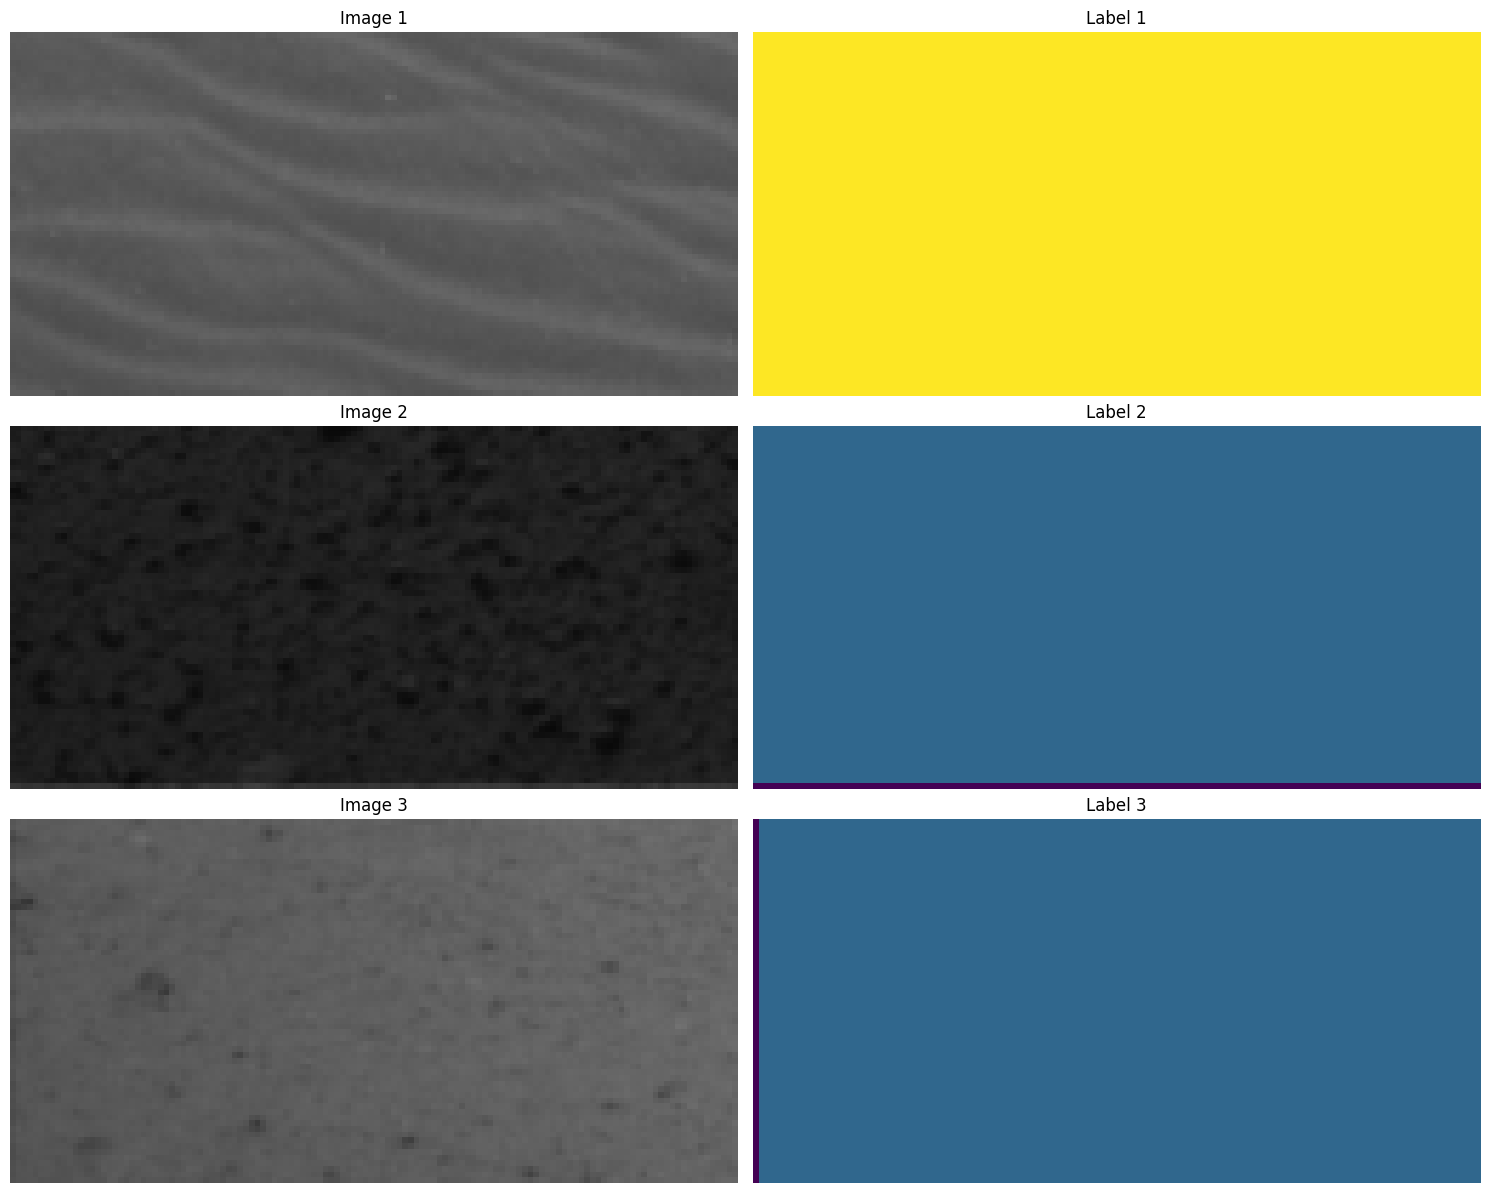

In [11]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j])
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=3)

## Build the Model

In [12]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [13]:
def get_unet_model(input_shape=(64, 128, 3), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, 128, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 3)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │       896 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 64, 128, │     9,248 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ down_block1_a… │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    18,496 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv2 │ (None, 32, 64,  │    36,928 │ down_block2_a… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn2   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_1   │ (None, 16, 32,  │         0 │ down_block2_a… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ bottleneckconv1   │ (None, 16, 32,  │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ bottleneckbn1     │ (None, 16, 32,  │       512 │ bottleneckcon… │   Y 

 Total params: 474,245 (1.81 MB)

 Trainable params: 472,965 (1.80 MB)

 Non-trainable params: 1,280 (5.00 KB)

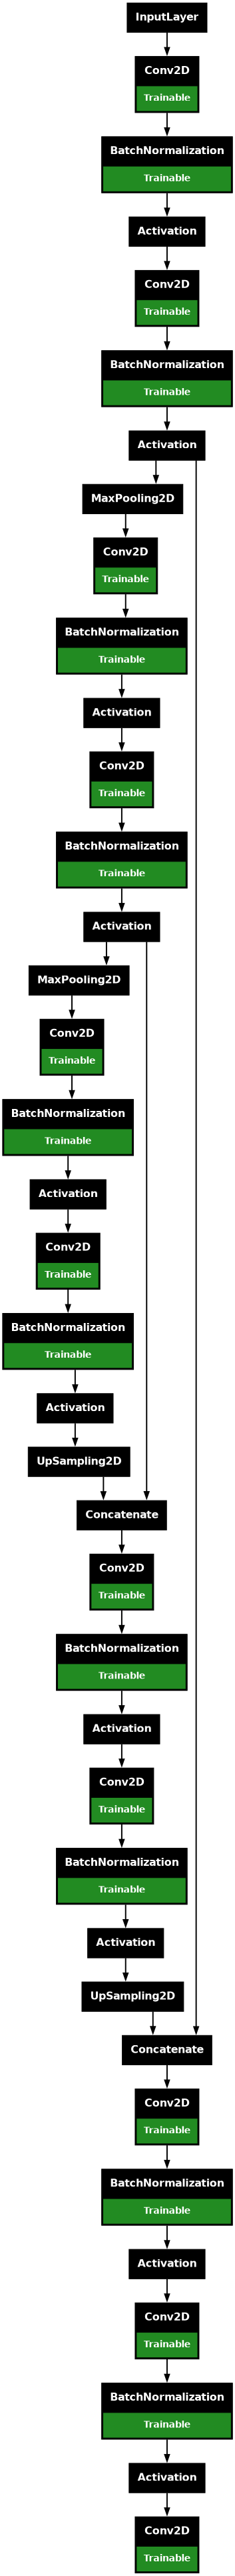

In [14]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [19]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_path, label_path, frequency=5):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = self.image_path, self.label_path
            label = apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [20]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


## 🛠️ Train the Model

In [21]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(val_img[0], val_lbl[0])

In [25]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping], ##############3, viz_callback],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

Epoch 1/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.6152 - loss: 0.9700 - mean_iou: 0.3324 - val_accuracy: 0.1614 - val_loss: 4.8513 - val_mean_iou: 0.0538
Epoch 2/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.6490 - loss: 0.8928 - mean_iou: 0.3678 - val_accuracy: 0.1614 - val_loss: 5.6839 - val_mean_iou: 0.0430
Epoch 3/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.6562 - loss: 0.8692 - mean_iou: 0.3728 - val_accuracy: 0.1614 - val_loss: 4.7913 - val_mean_iou: 0.0538
Epoch 4/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.6577 - loss: 0.8642 - mean_iou: 0.3743 - val_accuracy: 0.1611 - val_loss: 5.0861 - val_mean_iou: 0.0434
Epoch 5/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.6675 - loss: 0.8439 - mean_iou: 0.3864 - val_accuracy: 0.1603 - val_loss: 3.8586 - val_mean_iou: 0.0431
Epoch 6/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.6724 - loss: 0.8357 - mean_iou: 0.3878 - val_accuracy: 0.1616 - val_loss: 4.33

In [26]:
# Save the trained model to a file with the accuracy included in the filename
model_filename = 'model_unet.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.



In [57]:
X_test_submission = data["test_set"]
print(f"Test X shape: {X_test_submission.shape}")
X_test_submission = X_test_submission[..., np.newaxis] / 255.0
X_test_submission = tf.cast(X_test_submission, tf.float32)
X_test_submission = tf.image.grayscale_to_rgb(X_test_submission)


Test X shape: (10022, 64, 128)


In [58]:
# Load UNet model without compiling
model = tfk.models.load_model('/kaggle/working/model_unet.keras', compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 3)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │       896 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 64, 128, │     9,248 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ down_block1_a… │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    18,496 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv2 │ (None, 32, 64,  │    36,928 │ down_block2_a… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn2   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_1   │ (None, 16, 32,  │         0 │ down_block2_a… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ bottleneckconv1   │ (None, 16, 32,  │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ bottleneckbn1     │ (None, 16, 32,  │       512 │ bottleneckcon… │   Y 

 Total params: 474,245 (1.81 MB)

 Trainable params: 472,965 (1.80 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [59]:
preds = model.predict(X_test_submission)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
Predictions shape: (10022, 64, 128)


In [60]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

# Create and download the csv submission file
submission_filename = f"submission.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)